# Installing **Xplique** and utils

In [1]:
#!pip install -q xplique

import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

import xplique
from xplique.plots import plot_attributions

In [3]:
# import os
nb_samples = 50
input_size = 224#224
images_dir = '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data'

# Select only images with a '.png' extension
images_path = [f"{images_dir}/{p}" for p in os.listdir(images_dir) if p.lower().endswith('.png')][:nb_samples]

# Display the selected images
print(images_path)


['../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334751705_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334749778_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334732198_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334667886_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334646745_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334644872_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334670727_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334742590_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334653129_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334667862_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334667825_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334705685_image.png', '../Results/Table_To_Image_Conve_Sml_dos/Test_1/data/_334742836_image.png', '../Results

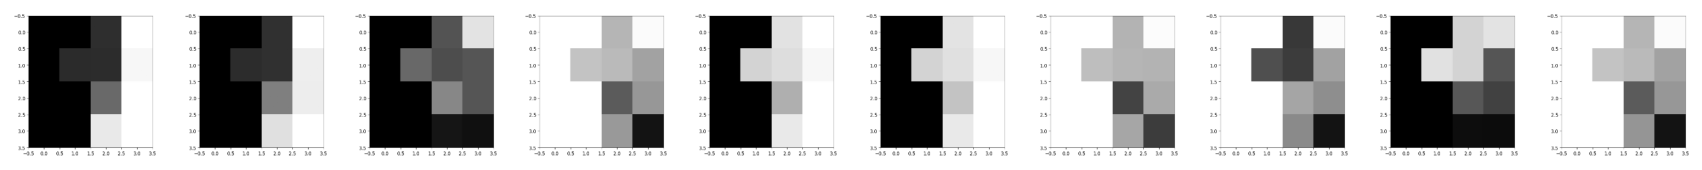

In [4]:

images = [cv2.imread(p)[...,::-1] for p in images_path]
images = tf.image.resize(images, (input_size, input_size))
images.shape

plt.rcParams["figure.figsize"] = [15, 5]
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(images[i]/255.0)
  plt.axis('off')

In [5]:
import tensorflow.keras.applications as app

model, preprocessing = app.MobileNetV2(), app.mobilenet_v2.preprocess_input

X = preprocessing(np.array(images, copy=True))
Y = tf.one_hot([1] * len(X), 1000) # class 1 is DoS

# 🔍 Generate explanations

💡 To explain the logits is to explain the class, to explain the softmax is to explain why this class rather than another. It is thus recommended to remove the softmax activation to explain the logit


Method: Lime


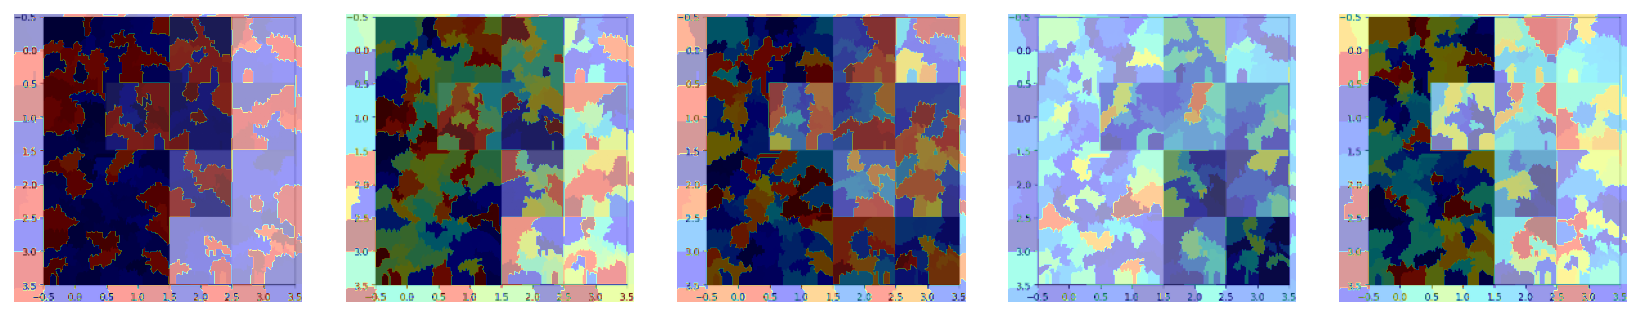



Method: KernelShap


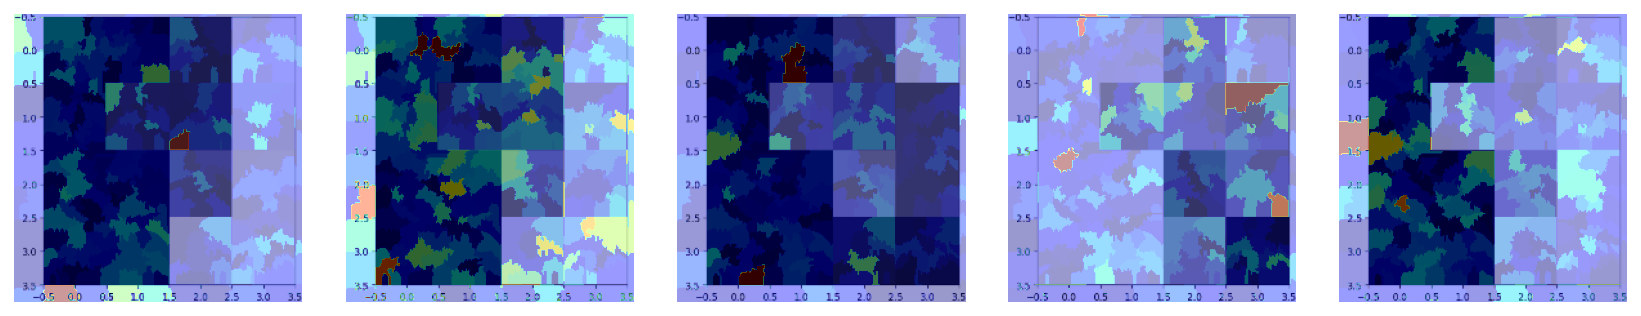

In [6]:
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, GradCAM, Occlusion, Rise, GuidedBackprop,
                                  GradCAMPP, Lime, KernelShap, SobolAttributionMethod)

# to explain the logits is to explain the class,
# to explain the softmax is to explain why this class rather than another
# it is therefore recommended to explain the logit
model.layers[-1].activation = tf.keras.activations.linear
batch_size = 64

explainers = [
            #  Saliency(model),
            #  GradientInput(model),
            #  GuidedBackprop(model),
            #  IntegratedGradients(model, steps=50, batch_size=batch_size),
            #  SmoothGrad(model, nb_samples=50, batch_size=batch_size),
            #  SquareGrad(model, nb_samples=50, batch_size=batch_size),
            #  VarGrad(model, nb_samples=50, batch_size=batch_size),
            #  GradCAM(model),
            #  GradCAMPP(model),
            #  Occlusion(model, patch_size=10, patch_stride=10, batch_size=batch_size),
            #  SobolAttributionMethod(model, batch_size=batch_size),
             # Rise(model, nb_samples=4000, batch_size=batch_size),
             Lime(model, nb_samples = 50),
             KernelShap(model, nb_samples = 50)
]

explanations_to_test = {}

for explainer in explainers:

  explainer_name = explainer.__class__.__name__
  explanations = explainer(X, Y)

  if len(explanations.shape) > 3:
    explanations = np.mean(explanations, -1)

  # store the explanations to use the metrics
  explanations_to_test[explainer_name] = explanations

  print(f"Method: {explainer_name}")
  plot_attributions(explanations[:5], X[:5], cmap='jet', alpha=0.4,
                    cols=5, clip_percentile=0.5, absolute_value=True)
  plt.show()
  print("\n")

# 🏅 Metrics

In [7]:
#%load_ext google.colab.data_table
import pandas as pd

# softmax or sigmoid are needed to correctly compute metrics this time
model = app.MobileNetV2()

## **Deletion** Metric

The deletion metric measures the drop in the probability of a class as important pixels (given by the saliency map) are gradually removed from the image. A sharp drop, and thus a small area under the probability curve, are indicative of a good explanation.

**Lower is better**

---

Petsiuk & al., RISE: Randomized Input Sampling for Explanation of Black-box Models (2018). https://arxiv.org/pdf/1806.07421.pdf

In [8]:
from xplique.metrics import Deletion

metric = Deletion(model, X, Y, batch_size)
deletion_scores = []

i = 0
for explanation_name, explanations in explanations_to_test.items():
  deletion_score = metric(explanations)
  deletion_scores.append((explanation_name, deletion_score))

pd.DataFrame(deletion_scores, columns=["Method name", "Deletion score (lower is better)"])

,Method name,Deletion score (lower is better)
0,Lime,0.000945
1,KernelShap,0.000889


## **Insertion** Metric

The insertion metric, on the other hand, captures the importance of the pixels in terms of their ability to synthesize an image and is measured by the rise in the probability of the class of interest as pixels are added according to the generated importance map.

**Higher is better**

---

Petsiuk & al., RISE: Randomized Input Sampling for Explanation of Black-box Models (2018). https://arxiv.org/pdf/1806.07421.pdf

In [9]:
from xplique.metrics import Insertion

metric = Insertion(model, X, Y, batch_size)
insertion_scores = []

i = 0
for explanation_name, explanations in explanations_to_test.items():
  insertion_score = metric(explanations)
  insertion_scores.append((explanation_name, insertion_score))

pd.DataFrame(insertion_scores, columns=["Method name", "Insertion score (higher is better)"])

,Method name,Insertion score (higher is better)
0,Lime,0.001084
1,KernelShap,0.001066


## **MuFidelity** Metric

Used to compute the fidelity correlation metric. This metric ensure there is a correlation between a random subset of pixels and their attribution score. For each random subset created, we set the pixels of the subset at a baseline state and obtain the prediction score. This metric measures the correlation between the drop in the score and the importance of the explanation.

**Higher is better**

---

Bhatt & al., Evaluating and Aggregating Feature-based Model Explanations (2020). https://arxiv.org/abs/2005.00631 (def. 3)

In [10]:
from xplique.metrics import MuFidelity

metric = MuFidelity(model, X, Y, batch_size, nb_samples=25)
fidelity_scores = []

i = 0
for explanation_name, explanations in explanations_to_test.items():
  fidelity_score = metric(explanations)
  fidelity_scores.append((explanation_name, fidelity_score))

pd.DataFrame(fidelity_scores, columns=["Method name", "Fidelity score (higher is better)"])

,Method name,Fidelity score (higher is better)
0,Lime,0.030954
1,KernelShap,0.008862


## **Stability** Metric

Used to compute the average sensitivity metric (or stability). This metric ensure that close inputs with similar predictions yields similar explanations. For each inputs we randomly sample noise to add to the inputs and compute the explanation for the noisy inputs. We then get the average distance between the original explanations and the noisy explanations.

**Lower is better**

---

Bhatt & al., Evaluating and Aggregating Feature-based Model Explanations (2020). https://arxiv.org/abs/2005.00631 (def. 2)

In [11]:
from xplique.metrics import AverageStability

metric = AverageStability(model, X[:20], Y[:20], batch_size, nb_samples=32)
stability_scores = []

i = 0
for explainer in explainers:
  explainer_name = explainer.__class__.__name__
  stability_score = metric(explainer)
  stability_scores.append((explainer_name, stability_score))

pd.DataFrame(stability_scores, columns=["Method name", "Stability score (lower is better)"])

,Method name,Stability score (lower is better)
0,Lime,0.006672
1,KernelShap,29.887222
